In [1]:
import glob
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import random
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.preprocessing import LabelEncoder
from keras.applications import resnet50, vgg16
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Lambda, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model, Sequential
from keras import optimizers
from keras import backend as K
from itertools import combinations, product
%matplotlib inline

Using TensorFlow backend.


In [2]:
# set to image directory
cov = glob.glob('/Users/austinau-yeung/Documents/Georgia Tech/1/ECE6254/project/covid-chestxray-dataset-master/output/*')
pne = glob.glob('/Users/austinau-yeung/Documents/Georgia Tech/1/ECE6254/project/pneumonia2/*')
# cov_avg = glob.glob('/Users/austinau-yeung/Documents/Georgia Tech/1/ECE6254/project/covidavg/*')

# parameters
cov_train_num = 35
pne_train_num = 35
cov_avg_num = 5;

In [3]:
num_classes = 2

# select random subset of images for training
cov_train = np.random.choice(cov,size=cov_train_num,replace=False)
pne_train = np.random.choice(pne,size=pne_train_num,replace=False)
cov_test = list(set(cov)-set(cov_train))
pne_test = list(set(pne)-set(pne_train))
cov_avg = np.random.choice(cov_test,size=cov_avg_num,replace=False)
cov_test = list(set(cov_test)-set(cov_avg))

cov_test_num = len(cov_test)
pne_test_num = len(pne_test)

print('COVID training set size: '+str(cov_train_num))
print('Pneumonia training set size: '+str(pne_train_num))
print('Total training set size: '+str(cov_train_num+pne_train_num))
print()
print('COVID testing set size: '+str(cov_test_num))
print('Pneumonia testing set size: '+str(pne_test_num))
print('Total testing set size: '+str(cov_test_num+pne_test_num))
print()
print('Number of COVID pictures to average for classifier: '+str(cov_avg_num))
print()
print('Maximum training pairs size:')
n = min([cov_train_num,pne_train_num])
n1 = cov_train_num
n2 = pne_train_num
print('     With class balance: '+str(2*n**2-n))
print('     Without class balance: '+str((n1*(n1-1))/2+(n2*(n2-1))/2+n1*n2))
print('Maximum testing pairs size:')
n = min([cov_test_num,pne_test_num])
n1 = cov_test_num
n2 = pne_test_num
print('     With class balance: '+str(2*n**2-n))
print('     Without class balance: '+str((n1*(n1-1))/2+(n2*(n2-1))/2+n1*n2))
print('Maximum classification pairs size:')
print('     With class balance: '+str(n*2))
print('     Without class balance: '+str(n1+n2))

COVID training set size: 35
Pneumonia training set size: 35
Total training set size: 70

COVID testing set size: 139
Pneumonia testing set size: 287
Total testing set size: 426

Number of COVID pictures to average for classifier: 5

Maximum training pairs size:
     With class balance: 2415
     Without class balance: 2415.0
Maximum testing pairs size:
     With class balance: 38503
     Without class balance: 90525.0
Maximum classification pairs size:
     With class balance: 278
     Without class balance: 426


In [4]:
# set following parameters to desired number of pairs according to output of above
train_balance = 1;
test_balance = 1;
cl_balance = 0;
num_tr_pairs = 2048;
num_te_pairs = 4096;

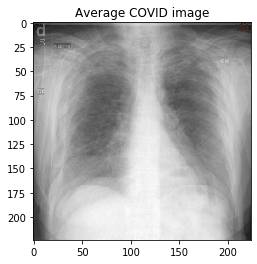

In [5]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_DIM = (IMG_WIDTH,IMG_HEIGHT)

# load training images
cov_train_imgs = [img_to_array(load_img(img,target_size=IMG_DIM,color_mode="rgb")) for img in cov_train]
pne_train_imgs = [img_to_array(load_img(img,target_size=IMG_DIM,color_mode="rgb")) for img in pne_train]

# create corresponding labels
train_imgs = np.array(cov_train_imgs+pne_train_imgs)
train_imgs_scaled = train_imgs.astype('float32')/255
train_labels = cov_train_num*['c']+pne_train_num*['p']

# load test images and create corresponding labels
cov_test_imgs = [img_to_array(load_img(img,target_size=IMG_DIM,color_mode="rgb")) for img in cov_test]
pne_test_imgs = [img_to_array(load_img(img,target_size=IMG_DIM,color_mode="rgb")) for img in pne_test]
test_imgs = np.array(cov_test_imgs+pne_test_imgs)
test_imgs_scaled = test_imgs.astype('float32')/255
test_labels = cov_test_num*['c']+pne_test_num*['p']

# create average covid image
covavg_imgs = np.array([img_to_array(load_img(img,target_size=IMG_DIM,color_mode="rgb")) for img in cov_avg])
covavg_imgs_scaled = covavg_imgs.astype('float32')/255
if len(covavg_imgs_scaled.shape)>3:
    covavg_imgs_scaled = np.expand_dims(np.mean(covavg_imgs_scaled,axis=0),axis=0)
plt.title('Average COVID image')
plt.imshow(array_to_img(covavg_imgs_scaled[0]))
plt.show()

input_shape = (IMG_HEIGHT,IMG_WIDTH,train_imgs.shape[3])

In [6]:
# encode class labels as 0/1
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
test_labels_enc = le.transform(test_labels)

In [7]:
# siamese network and auxiliary functions referenced from the following:
# https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 2
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 1
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 1, y_true.dtype)))

def create_pairs(x, class_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(class_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = class_indices[d][i], class_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = class_indices[d][i], class_indices[dn][random.randrange(0,n+1)]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

def create_all_pairs(x, class_indices, balance, limit):
    '''Positive and negative pair creation.
    Use "balance" to toggle positive/negative pair balance.
    Use "limit" to limit the number of pairs and conserve memory.
    '''
    pairs = []
    labels = []

    # create all positive pairs for each class (two classes: (N choose 2)*2=N^2-N)
    for d in range(num_classes):
        if balance:
            n = min([len(class_indices[d]) for d in range(num_classes)])
        else:
            n = len(class_indices[d])
        comb = list(combinations(range(0,n),2)) # select indices in class
        comb = random.sample(comb,int((limit/2)/num_classes))
        for i in comb:
            z1, z2 = class_indices[d][i[0]], class_indices[d][i[1]]
            pairs += [[x[z1], x[z2]]]
            labels += [1]
    
    # create all possible negative pairs (two classes: N^2)
    comb = list(combinations(range(0,num_classes),2)) # select two different classes
    for d in comb:
        if balance:
            n0 = n
            n1 = n
        else:
            n0 = len(class_indices[d[0]])
            n1 = len(class_indices[d[1]])
        comb2 = list(product(range(n0),range(n1)))
        comb2 = random.sample(comb2,int((limit/2)/len(comb)))
        for e in comb2:
            z1, z2 = class_indices[d[0]][e[0]], class_indices[d[1]][e[1]]
            pairs += [[x[z1], x[z2]]]
            labels += [0]

    return np.array(pairs), np.array(labels)

def covavg_pairs(x1,x2,class_indices,balance):
    '''Assumes two classes. Assumes class 0 of x2 matches x1.'''
    pairs = []
    labels = []
    n = min([len(class_indices[d]) for d in range(num_classes)])
    if balance:
        n0 = n
        n1 = n
    else:
        n0 = len(class_indices[0])
        n1 = len(class_indices[1])
    
    # create all positive pairs for each class
    for i in range(n0):
        z = class_indices[0][i]
        pairs += [[x1[0], x2[z]]]
        labels += [1]
    
    # create all possible negative pairs
    for i in range(n1):
        z = class_indices[1][i]
        pairs += [[x1[0], x2[z]]]
        labels += [0] 
                
    return np.array(pairs), np.array(labels)

In [8]:
# create positive and negative pairs
idx = [np.where(train_labels_enc==i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_all_pairs(train_imgs_scaled,idx,train_balance,num_tr_pairs)

idx = [np.where(test_labels_enc==i)[0] for i in range(num_classes)]
te_pairs, te_y = create_all_pairs(test_imgs_scaled,idx,test_balance,num_te_pairs)
cl_pairs, cl_y = covavg_pairs(covavg_imgs_scaled,test_imgs_scaled,idx,cl_balance)

print('Balancing training pairs: '+str(train_balance==1))
print('Balancing testing pairs: '+str(test_balance==1))
print('Balancing classification pairs: '+str(cl_balance==1))
print()
print('Training pairs size: '+str(tr_pairs.shape[0]))
print('Testing pairs size: '+str(te_pairs.shape[0]))
print('Classification pairs size: '+str(cl_pairs.shape[0]))

Balancing training pairs: True
Balancing testing pairs: True
Balancing classification pairs: False

Training pairs size: 2048
Testing pairs size: 4096
Classification pairs size: 426


In [9]:
def vggnet_base(input_shape):
    # exclude top 3 fully-connected layers and train last 5 of remaining layers
    vggnet = vgg16.VGG16(include_top=False,weights='imagenet',input_shape=input_shape,pooling='avg')
    for layer in vggnet.layers[-5:]:
        layer.trainable=True
    for layer in vggnet.layers[:-5]:
        layer.trainable=False
    x = vggnet.output
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
        
    return Model(vggnet.input,x)

# create siamese network with euclidean distance as final layer
base_network = vggnet_base(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          14796864    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]              

In [10]:
adm = optimizers.Adam(lr=0.0001)
model.compile(loss=contrastive_loss, optimizer=adm, metrics=[accuracy])

# use unedited training images
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=10,
#           validation_data=([te_pairs[:10, 0], te_pairs[:10, 1]], te_y[:10]), # validate on small subset of testing dataset
          shuffle=True)

tr_y_dist = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, tr_y_dist)
te_y_dist = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, te_y_dist)
cl_y_dist = model.predict([cl_pairs[:, 0], cl_pairs[:, 1]])
cl_acc = compute_accuracy(cl_y, cl_y_dist)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))
print('* Accuracy on classification set: %0.2f%%' % (100 * cl_acc))

Epoch 1/10
2048/2048 [==============================] - 677s 330ms/step - loss: 1.0922 - accuracy: 0.5225
Epoch 2/10
2048/2048 [==============================] - 690s 337ms/step - loss: 0.7983 - accuracy: 0.6855
Epoch 3/10
2048/2048 [==============================] - 733s 358ms/step - loss: 0.2383 - accuracy: 0.9907
Epoch 4/10
2048/2048 [==============================] - 705s 344ms/step - loss: 0.1202 - accuracy: 0.9995
Epoch 5/10
2048/2048 [==============================] - 705s 344ms/step - loss: 0.0872 - accuracy: 1.0000
Epoch 6/10
2048/2048 [==============================] - 702s 343ms/step - loss: 0.0693 - accuracy: 1.0000
Epoch 7/10
2048/2048 [==============================] - 765s 374ms/step - loss: 0.0585 - accuracy: 1.0000
Epoch 8/10
2048/2048 [==============================] - 733s 358ms/step - loss: 0.0533 - accuracy: 1.0000
Epoch 9/10
2048/2048 [==============================] - 756s 369ms/step - loss: 0.0476 - accuracy: 1.0000
Epoch 10/10
2048/2048 [=======================

In [11]:
def generate_label(y_pred, threshold):
    '''Compute classification labels with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < threshold
    return pred

def generate_metrics(y_true,y_pred):
    tp = sum(y_true+y_pred==2)
    tn = sum(y_true+y_pred==0)
    fp = sum(y_true-y_pred==-1)
    fn = sum(y_true-y_pred==1)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    
    return np.array([tp,tn,fp,fn,sensitivity,specificity])

threshold = 1
cl_y_pred = generate_label(cl_y_dist,threshold) # using half of margin for threshold
tp,tn,fp,fn,sensitivity,specificity = generate_metrics(cl_y,cl_y_pred)
print('True positives: '+str(tp))
print('True negatives: '+str(tn))
print('False positives: '+str(fp))
print('False negatives: '+str(fn))
print('Sensitivity: '+str(sensitivity))
print('Specificity: '+str(specificity))

True positives: 135.0
True negatives: 251.0
False positives: 36.0
False negatives: 4.0
Sensitivity: 0.9712230215827338
Specificity: 0.8745644599303136
